# Sentiment Analysis
Now that we've seen word vectors we can start to investigate sentiment analysis. The goal is to find commonalities between documents, with the understanding that similarly *combined* vectors should correspond to similar sentiments.

While the scope of sentiment analysis is very broad, we will focus our work in two ways.

### 1. Polarity classification
We won't try to determine if a sentence is objective or subjective, fact or opinion. Rather, we care only if the text expresses a *positive*, *negative* or *neutral* opinion.
### 2. Document level scope
We'll also try to aggregate all of the sentences in a document or paragraph, to arrive at an overall opinion.
### 3. Coarse analysis
We won't try to perform a fine-grained analysis that would determine the degree of positivity/negativity. That is, we're not trying to guess how many stars a reviewer awarded, just whether the review was positive or negative.

## Broad Steps:
* First, consider the text being analyzed. A model trained on paragraph-long movie reviews might not be effective on tweets. Make sure to use an appropriate model for the task at hand.
* Next, decide the type of analysis to perform. In the previous section on text classification we used a bag-of-words technique that considered only single tokens, or *unigrams*. Some rudimentary sentiment analysis models go one step further, and consider two-word combinations, or *bigrams*. In this section, we'd like to work with complete sentences, and for this we're going to import a trained NLTK lexicon called *VADER*.

## NLTK's VADER module
VADER is an NLTK module that provides sentiment scores based on words used ("completely" boosts a score, while "slightly" reduces it), on capitalization & punctuation ("GREAT!!!" is stronger than "great."), and negations (words like "isn't" and "doesn't" affect the outcome).
<br>To view the source code visit https://www.nltk.org/_modules/nltk/sentiment/vader.html

In [1]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/brandonkwamou/nltk_data...


True

In [2]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

VADER's `SentimentIntensityAnalyzer()` takes in a string and returns a dictionary of scores in each of four categories:
* negative
* neutral
* positive
* compound *(computed by normalizing the scores above)*

In [3]:
a = "This is a good movie"

sid.polarity_scores(a)

{'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'compound': 0.4404}

In [5]:
a = "This was the best, most awesome movie EVER MADE!!!"

sid.polarity_scores(a)

{'neg': 0.0, 'neu': 0.425, 'pos': 0.575, 'compound': 0.8877}

In [6]:
a = "This was the WORST movie that has ever disgraced the screen."

sid.polarity_scores(a)

{'neg': 0.465, 'neu': 0.535, 'pos': 0.0, 'compound': -0.8331}

## Use VADER to analyze Amazon Reviews
For this exercise we're going to apply `SentimentIntensityAnalyzer` to a dataset of 10,000 Amazon reviews. Like our movie reviews datasets, these are labeled as either "pos" or "neg". At the end we'll determine the accuracy of our sentiment analysis with VADER.

In [7]:
import pandas as pd

df = pd.read_csv('./amazonreviews.tsv', sep="\t")
df.head()

,label,review
0,pos,Stuning even for the non-gamer: This sound tra...
1,pos,The best soundtrack ever to anything.: I'm rea...
2,pos,Amazing!: This soundtrack is my favorite music...
3,pos,Excellent Soundtrack: I truly like this soundt...
4,pos,"Remember, Pull Your Jaw Off The Floor After He..."


In [8]:
df['label'].value_counts()

label
neg    5097
pos    4903
Name: count, dtype: int64

### Clean the data (optional):
Recall that our moviereviews.tsv file contained empty records. Let's check to see if any exist in amazonreviews.tsv.

In [9]:
# remove NAN value
df.dropna(inplace=True)

# remove empty review string
blanks = []

for i,lb,rv in df.itertuples():
    if type(rv) == str:
        if rv.isspace():
            blanks.append(i)

df.drop(blanks,inplace=True)

In [10]:
df['label'].value_counts()

label
neg    5097
pos    4903
Name: count, dtype: int64

In this case there were no empty records or NA cells. Good!

## Let's run the first review through VADER

In [11]:
sid.polarity_scores(df.iloc[0]['review'])

{'neg': 0.088, 'neu': 0.669, 'pos': 0.243, 'compound': 0.9454}

## Adding Scores and Labels to the DataFrame
In this next section we'll add columns to the original DataFrame to store polarity_score dictionaries, extracted compound scores, and new "pos/neg" labels derived from the compound score. We'll use this last column to perform an accuracy test.

In [12]:
df['scores'] = df['review'].apply(lambda rv: sid.polarity_scores(rv))

In [13]:
df.head()

,label,review,scores
0,pos,Stuning even for the non-gamer: This sound tra...,"{'neg': 0.088, 'neu': 0.669, 'pos': 0.243, 'co..."
1,pos,The best soundtrack ever to anything.: I'm rea...,"{'neg': 0.018, 'neu': 0.837, 'pos': 0.145, 'co..."
2,pos,Amazing!: This soundtrack is my favorite music...,"{'neg': 0.04, 'neu': 0.692, 'pos': 0.268, 'com..."
3,pos,Excellent Soundtrack: I truly like this soundt...,"{'neg': 0.09, 'neu': 0.615, 'pos': 0.295, 'com..."
4,pos,"Remember, Pull Your Jaw Off The Floor After He...","{'neg': 0.0, 'neu': 0.746, 'pos': 0.254, 'comp..."


In [14]:
df['compound'] = df['scores'].apply(lambda d: d['compound'])
df.head()

,label,review,scores,compound
0,pos,Stuning even for the non-gamer: This sound tra...,"{'neg': 0.088, 'neu': 0.669, 'pos': 0.243, 'co...",0.9454
1,pos,The best soundtrack ever to anything.: I'm rea...,"{'neg': 0.018, 'neu': 0.837, 'pos': 0.145, 'co...",0.8957
2,pos,Amazing!: This soundtrack is my favorite music...,"{'neg': 0.04, 'neu': 0.692, 'pos': 0.268, 'com...",0.9858
3,pos,Excellent Soundtrack: I truly like this soundt...,"{'neg': 0.09, 'neu': 0.615, 'pos': 0.295, 'com...",0.9814
4,pos,"Remember, Pull Your Jaw Off The Floor After He...","{'neg': 0.0, 'neu': 0.746, 'pos': 0.254, 'comp...",0.9781


In [15]:
df['comp_score'] = df['compound'].apply(lambda score: 'pos' if score >= 0 else 'neg')
df.head()

,label,review,scores,compound,comp_score
0,pos,Stuning even for the non-gamer: This sound tra...,"{'neg': 0.088, 'neu': 0.669, 'pos': 0.243, 'co...",0.9454,pos
1,pos,The best soundtrack ever to anything.: I'm rea...,"{'neg': 0.018, 'neu': 0.837, 'pos': 0.145, 'co...",0.8957,pos
2,pos,Amazing!: This soundtrack is my favorite music...,"{'neg': 0.04, 'neu': 0.692, 'pos': 0.268, 'com...",0.9858,pos
3,pos,Excellent Soundtrack: I truly like this soundt...,"{'neg': 0.09, 'neu': 0.615, 'pos': 0.295, 'com...",0.9814,pos
4,pos,"Remember, Pull Your Jaw Off The Floor After He...","{'neg': 0.0, 'neu': 0.746, 'pos': 0.254, 'comp...",0.9781,pos


## Report on Accuracy
Finally, we'll use scikit-learn to determine how close VADER came to our original 10,000 labels.

In [16]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

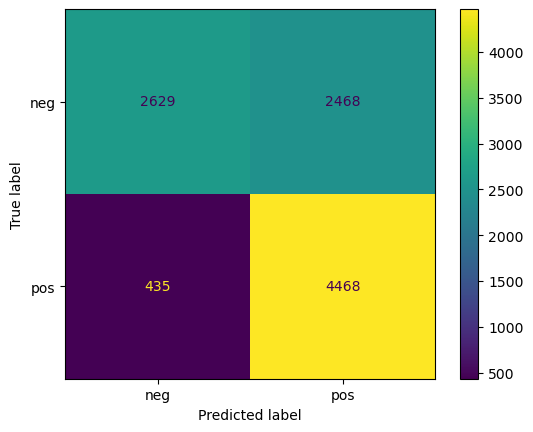

In [19]:
ConfusionMatrixDisplay.from_predictions(df['label'],df['comp_score'])

In [18]:
print(classification_report(df['label'],df['comp_score']))

              precision    recall  f1-score   support

         neg       0.86      0.52      0.64      5097
         pos       0.64      0.91      0.75      4903

    accuracy                           0.71     10000
   macro avg       0.75      0.71      0.70     10000
weighted avg       0.75      0.71      0.70     10000



This tells us that VADER correctly identified an Amazon review as "positive" or "negative" roughly 71% of the time.